In [2]:
import matplotlib.pyplot as plt  # for making figures
import torch
import torch.nn.functional as F

%matplotlib inline
import requests

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read in all the words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
).text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [7]:
def cmp(name: str, dt: torch.Tensor, t: torch.Tensor) -> None:
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{name:15s} | exact {str(ex):5s} | approx {str(app):5s} | maxdiff {maxdiff:8.3f}")

In [8]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1

# DIMENSIONS = 30, 64

W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)  # Initialization Kaiming He: W / sqrt(fan_in) * 5/3
b1 = torch.randn(n_hidden, generator=g) * 0.1  # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
gamma = torch.randn((1, n_hidden)) * 0.1 + 1.0
beta = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, gamma, beta]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [1]:
# Batch norm steps:
# 1. Compute mean and variance of the input


# [a, a, b, c, d]
[2, 1, 1, 1]
[2 / 5, 1 / 5, 1 / 5, 1 / 5]

[0.4, 0.2, 0.2, 0.2]

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = gamma * bnraw + beta
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
#
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,  # afaik there is no cleaner way
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4947, grad_fn=<NegBackward0>)

In [ ]:
# f(x) = ax
# f'(x) = a

# probs = counts * counts_sum_inv
# probs' = counts_sum_inv

In [ ]:
# [a, b, c, d].mean() -> (a+b+c+d)/n -> a/n + b/n + c/n + d/n
# da = 1/n
# db = 1/n
# dc = 1/n
# dd = 1/n

In [158]:
logits.max(1).indices

tensor([ 1,  2, 19, 15, 15, 25, 16,  3, 19,  8, 15,  3, 22,  5, 20,  5,  2,  1,
        22, 19, 15, 19, 22, 22, 23,  5, 22, 20, 24, 15, 24, 13])

In [164]:
# [1, 2, 1, 6, 2].max() -> 6
# [0, 0, 0, 1, 0].max() -> 1

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_7624/2399939212.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.one_hot(torch.tensor(logits.max(1).indices), num_classes=logits.shape[1]) * dlogit_maxes


tensor([[ 0.0000e+00,  2.7940e-09,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.3970e-09,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.00

In [170]:
dlogits.shape, h.shape, W2.shape, W2.T.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27, 64]))

In [175]:
h.T.shape, dlogits.shape

(torch.Size([64, 32]), torch.Size([32, 27]))

In [181]:
db2.shape

torch.Size([32, 27])

In [ ]:
# a, b, c, d  = (a + b + c + d) / n = (a/n + b/n + c/n + d/n)

In [ ]:
# f(x) = x * 1/n

In [ ]:
# [0.5, 0.3, 0.2], [0.3, 0.3, 0.4], [0.1, 0.7, 0.2]
# [0, 1, 1]

# [0, 0, 0], [0, 0, 0], [0, 0, 0]
# grad = -1/n
# [-1/n, 0, 0], [0, -1/n, 0], [0, -1/n, 0]

In [ ]:
# f(x) = a * x
# f'(x) = a

# f(x) = x^a
# f'(x) = a * x^(a-1)


# f(x) = x + a + b + c
# f'(x) = 1

# f(x) = exp(x)
# f'(x) = exp(x)

In [ ]:
# [-3, 2, 5], [-100, 2, 0]
# max([-3, 2, 5], [-100, 2, 0]) -> [5, 2]
# [0, 0, 1], [0, 1, 0]

In [12]:
dlogits.shape, logits.shape, h.shape, W2.shape, W2.T.shape

(torch.Size([32, 27]),
 torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27, 64]))

In [ ]:
# 32, 64
# 64, 64

In [13]:
h.shape, dlogits.shape, W2.shape

# 64, 32 -> 64, 27
# 32, 27

(torch.Size([32, 64]), torch.Size([32, 27]), torch.Size([64, 27]))

In [18]:
dhpreact.sum(0, keepdim=True).shape

torch.Size([1, 64])

In [14]:
gamma.shape

torch.Size([1, 64])

In [16]:
beta.shape

torch.Size([1, 64])

In [22]:
dbnraw.shape

torch.Size([32, 64])

In [21]:
bnvar.shape

torch.Size([1, 64])

In [25]:
dbnvar.shape

torch.Size([1, 64])

In [28]:
torch.zeros_like(bndiff2)

torch.Size([32, 64])

In [33]:
bnmeani.shape

torch.Size([1, 64])

In [32]:
dbndiff.shape

torch.Size([32, 64])

In [43]:
dembcat.view(emb.shape).shape

torch.Size([32, 3, 10])

In [41]:
emb.shape

torch.Size([32, 3, 10])

In [47]:
Xb.shape[0]

32

In [ ]:
# f(x) = x + a
# f'(x) = 1

# f(x) = x^a
# f'(x) = a * x^(a-1)

# f(x) = a * x
# f'(x) = a

In [49]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logit = counts * dcounts
dlogits = dnorm_logit.clone()
dlogit_maxes = (-dnorm_logit).sum(1, keepdim=True)
dlogits += (
    F.one_hot(torch.tensor(logits.max(1).indices), num_classes=logits.shape[1]) * dlogit_maxes
)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dgamma = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = gamma * dhpreact
dbeta = (dhpreact).sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = 1 / (n - 1) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2 * bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += 1 / n * torch.ones_like(hprebn) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.clone().view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp("dlogprobs", dlogprobs, logprobs)
cmp("dprobs", dprobs, probs)
cmp("dcounts", dcounts, counts)
cmp("dcounts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("dcounts_sum", dcounts_sum, counts_sum)
cmp("dnorm_logit", dnorm_logit, norm_logits)
cmp("dlogits", dlogits, logits)
cmp("dlogit_maxes", dlogit_maxes, logit_maxes)
cmp("dh", dh, h)
cmp("dW2", dW2, W2)
cmp("db2", db2, b2)
cmp("dhpreact", dhpreact, hpreact)
cmp("dgamma", dgamma, gamma)
cmp("dbnraw", dbnraw, bnraw)
cmp("dbeta", dbeta, beta)
cmp("dbndiff", dbndiff, bndiff)
cmp("dbvar", dbnvar, bnvar)
cmp("dbndiff2", dbndiff2, bndiff2)
cmp("dbnmeani", dbnmeani, bnmeani)
cmp("dhprebn", dhprebn, hprebn)
cmp("dembcat", dembcat, embcat)
cmp("dW1", dW1, W1)
cmp("db1", db1, b1)
cmp("demb", demb, emb)
cmp("dC", dC, C)

dlogprobs       | exact True  | approx True  | maxdiff    0.000
dprobs          | exact True  | approx True  | maxdiff    0.000
dcounts         | exact True  | approx True  | maxdiff    0.000
dcounts_sum_inv | exact True  | approx True  | maxdiff    0.000
dcounts_sum     | exact True  | approx True  | maxdiff    0.000
dnorm_logit     | exact True  | approx True  | maxdiff    0.000
dlogits         | exact True  | approx True  | maxdiff    0.000
dlogit_maxes    | exact True  | approx True  | maxdiff    0.000
dh              | exact True  | approx True  | maxdiff    0.000
dW2             | exact True  | approx True  | maxdiff    0.000
db2             | exact True  | approx True  | maxdiff    0.000
dhpreact        | exact True  | approx True  | maxdiff    0.000
dgamma          | exact True  | approx True  | maxdiff    0.000
dbnraw          | exact True  | approx True  | maxdiff    0.000
dbeta           | exact True  | approx True  | maxdiff    0.000
dbndiff         | exact True  | approx T

/var/folders/3t/wmv3mchd6w99pw9syrlwn5kh0000gq/T/ipykernel_67833/3199161054.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dlogits += F.one_hot(torch.tensor(logits.max(1).indices), num_classes=logits.shape[1]) * dlogit_maxes


In [127]:
counts_sum_inv.shape

torch.Size([32, 1])

In [50]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff", (loss_fast - loss).item())

3.494699001312256 diff 0.0


In [59]:
probs - F.softmax(logits, dim=1)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.00

In [61]:
print("diff probs and F.softmax(logits)", (probs - F.softmax(logits, dim=1)).abs().sum())

diff probs and F.softmax(logits) tensor(3.5111e-07, grad_fn=<SumBackward0>)


In [52]:
probs

tensor([[0.0342, 0.0191, 0.0310, 0.0227, 0.0413, 0.0611, 0.0777, 0.0201, 0.0357,
         0.0341, 0.0322, 0.0309, 0.0494, 0.0503, 0.0580, 0.0615, 0.0519, 0.0189,
         0.0281, 0.0321, 0.0486, 0.0135, 0.0223, 0.0228, 0.0319, 0.0296, 0.0408],
        [0.0206, 0.0549, 0.0421, 0.0230, 0.0292, 0.0571, 0.0223, 0.0199, 0.0182,
         0.0287, 0.0648, 0.0316, 0.0320, 0.0189, 0.0171, 0.0228, 0.0234, 0.0159,
         0.0636, 0.0543, 0.0162, 0.0289, 0.0232, 0.0866, 0.1120, 0.0381, 0.0346],
        [0.0441, 0.0188, 0.0320, 0.0155, 0.0783, 0.0285, 0.0400, 0.0295, 0.0301,
         0.0501, 0.0252, 0.0390, 0.0407, 0.0465, 0.0297, 0.0345, 0.0529, 0.0324,
         0.0391, 0.0192, 0.0337, 0.0168, 0.1095, 0.0165, 0.0363, 0.0423, 0.0187],
        [0.0168, 0.0375, 0.0367, 0.0302, 0.0158, 0.0392, 0.0620, 0.0559, 0.0582,
         0.0218, 0.0232, 0.0342, 0.0581, 0.0719, 0.0268, 0.0343, 0.0143, 0.0313,
         0.0255, 0.1119, 0.0606, 0.0175, 0.0250, 0.0230, 0.0244, 0.0257, 0.0182],
        [0.0384, 0.0309,

In [67]:
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1.0
dlogits /= n

cmp("dlogits", dlogits, logits)

dlogits         | exact False | approx True  | maxdiff    0.000


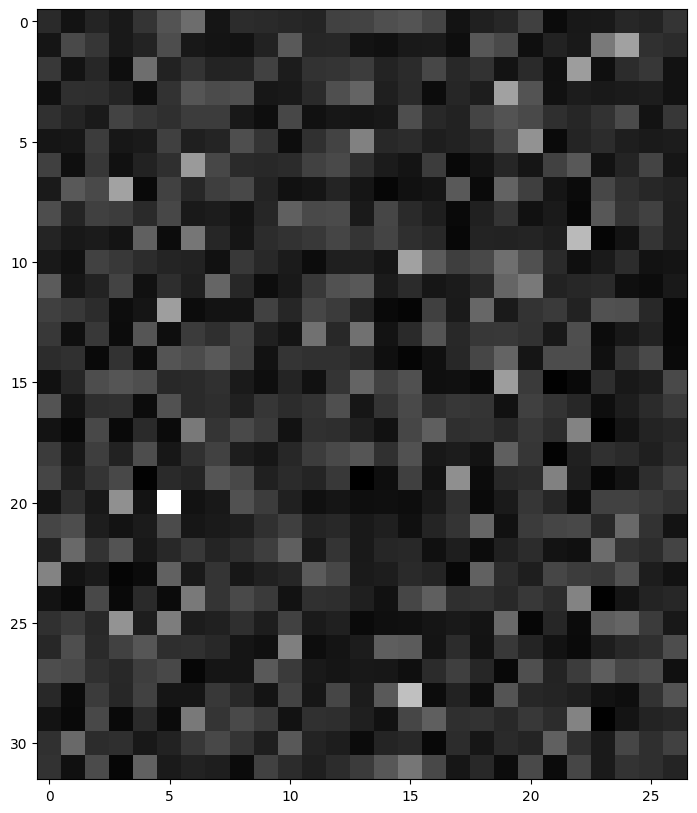

In [72]:
plt.figure(figsize=(10, 10))
plt.imshow(F.softmax(logits, dim=1).detach(), cmap="gray")

In [76]:
Yb

tensor([18,  0, 13, 14,  4, 12, 24,  5, 14,  8,  4, 18, 11, 15, 14, 18, 12,  2,
        21,  1, 16,  1,  0,  1, 13,  0, 12, 16, 25,  3,  1,  1])

In [77]:
dlogits[0]

tensor([ 0.0011,  0.0006,  0.0010,  0.0007,  0.0013,  0.0019,  0.0024,  0.0006,
         0.0011,  0.0011,  0.0010,  0.0010,  0.0015,  0.0016,  0.0018,  0.0019,
         0.0016,  0.0006, -0.0304,  0.0010,  0.0015,  0.0004,  0.0007,  0.0007,
         0.0010,  0.0009,  0.0013], grad_fn=<SelectBackward0>)

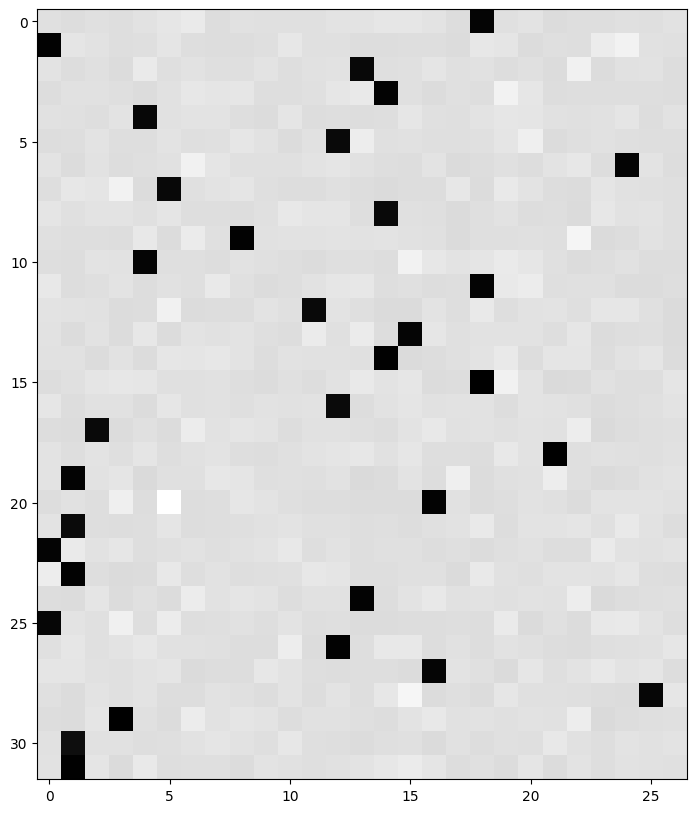

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(F.softmax(dlogits, dim=1).detach(), cmap="gray")